##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split as trainTestSplitter

####  <font color=SlateBlue>Google Colab</font>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

####  <font color=SlateBlue>Preprocessing</font>

In [ ]:
#Tokenizing 
import nltk
nltk.download('punkt')

import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
# from torchtext.legacy.data import Field, TabularDataset
from torchtext.data import Field, TabularDataset

####  <font color=SlateBlue>Reading .txt File</font>

In [ ]:
import re

####  <font color=SlateBlue>CNN</font> ####

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

####  <font color=SlateBlue>Model Evaluation</font> ####

In [ ]:
import itertools
from sklearn.metrics import accuracy_score as calcAccScore
from sklearn.metrics import classification_report as reportClassificationResults
from sklearn.metrics import confusion_matrix as confMat

##  <font color=MediumSlateBlue>Reading Data and Saving .csv File</font> ##

####  <font color=SlateBlue>Read and save to csv class where the given file is read, the extra not needed parts are excluded and the remaining desirable sentences and their corresponding lable are kept in a csv file.</font> ####

In [ ]:
class ReadAndSaveCSV():
  def __init__(self, filePath):
    self.filePath = filePath

  def readEachLine(self):
    self.fileLines = []
    with open(self.filePath, 'r') as file:
      allLines = file.readlines()
      self.fileLines += [line.strip() for line in allLines if not line=='\n']

  def removeComment(self):
    for line in self.fileLines:
      commentLine = re.search(r"\AComment", line)
      if not commentLine==None:
        self.fileLines.remove(line)
      else:
        continue
  
  def splitLines(self):
    temp = []

    for line in self.fileLines:
      temp.append(line.split('|'))

    self.fileLines = temp

  def separateRelationAndSentence(self):
    self.relations = []
    self.sentences = []

    for lineNum, lineContent in enumerate(self.fileLines,1):
      if (lineNum%2==0):
        self.relations.append(lineContent)
      else:
        self.sentences.append(lineContent)

  def setClassIndex(self):
    refDict = {'Cause-Effect':0, 
               'Instrument-Agency':1,
               'Product-Producer':2, 
               'Content-Container':3,
               'Entity-Origin':4, 
               'Entity-Destination':5,
               'Component-Whole':6, 
               'Member-Collection':7,
               'Message-Topic':8, 
               'Other':9
               }
    
    h = np.array(self.relations).shape
    indxRelations = np.zeros((h), dtype=np.int32)

    for key in refDict:
      idx = (np.array(self.relations)==np.array(key))
      validx = (idx==True) 
      indxRelations[validx] = np.array(refDict[key], dtype=np.int32)

    self.relations = indxRelations.tolist()

  def fixRelations(self, desiredLen=None):
    if not desiredLen==None:
      self.relations = self.relations[0:desiredLen]

    temp = ','.join(str(word) for relation in self.relations for word in relation)
    self.relations = re.sub(r'\([^)]*\)', "",temp).split(',')

    self.setClassIndex()

  def findEntities(self, sentence):
    sentence = sentence.replace('<e1>', ' START1 ').replace('</e1>', ' END1 ')
    sentence = sentence.replace('<e2>', ' START2 ').replace('</e2>', ' END2 ')

    for punc in string.punctuation:
      sentence = sentence.replace(punc, ' ')

    sentence = nltk.word_tokenize(sentence)

    start1 = sentence.index('START1')
    end1 = sentence.index('END1')
    start2 = sentence.index('START2')
    end2 = sentence.index('END2')

    return (start1,end1-1), (start2-2,end2-3)
    
  def fixSentences(self, desiredLen=None):
    if not desiredLen==None:
      self.sentences = self.sentences[0:desiredLen]

    temp = []
    self.entities = {'e1':[], 'e2':[]}

    for sentence in self.sentences:
      sentence = ''.join(sentence)
      sentence = re.sub('\t','',sentence)
      e1, e2 = self.findEntities(sentence)
      self.entities['e1'].append(e1)
      self.entities['e2'].append(e2)
      sentence = sentence.lstrip('0123456789.-')
      sentence = re.sub('<[^>]*>', '', sentence)
      sentence = sentence.replace('"', '')
      temp.append(sentence)

    self.sentences = temp

  def toCSV(self, fileLoc):
    allData = zip(self.sentences, self.relations, self.entities['e1'], self.entities['e2'])
    df = pd.DataFrame(allData, columns=['Sentences', 'Relations', 'Entity1', 'Entity2'])

    for punc in string.punctuation:
      df['Sentences'] = df.Sentences.str.replace(punc, " ")

    df.to_csv(fileLoc, index=False)  

  def performReadAndSave(self, fileLoc, desiredLen=None):
    self.readEachLine()
    self.removeComment()
    self.splitLines()
    self.separateRelationAndSentence()
    self.fixRelations(desiredLen)
    self.fixSentences(desiredLen)
    self.toCSV(fileLoc)


####  <font color=SlateBlue>Reading train file and altering it in the required manner. </font> ####

In [ ]:
TrainFilePath = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/TRAIN_FILE.TXT'

myFileSaver = ReadAndSaveCSV(TrainFilePath)
myFileSaver.performReadAndSave('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File_with_Entity.csv', 7109)

####  <font color=SlateBlue>Reading test file and altering it in the required manner. </font> ####

In [ ]:
TestFilePath = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/TEST_FILE.TXT'

myFileSaver = ReadAndSaveCSV(TestFilePath)
myFileSaver.performReadAndSave('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Test_File_with_Entity.csv')

##  <font color=MediumSlateBlue>Split Train and Validation Datasets</font> ##

####  <font color=SlateBlue>Splitting the train dataset into train and validation datasets. About 20% of train dataset is introduced as validation dataset. </font> ####

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File_with_Entity.csv')
trainDF, validDF = trainTestSplitter(df, test_size=0.2, random_state=42)
trainDF.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File_with_Entity.csv', index=False)
validDF.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Validation_File_with_Entity.csv', index=False)

##  <font color=MediumSlateBlue>Building Vocabulary</font> ##

####  <font color=SlateBlue>Vocabulary class which calculates the tokenized represetation of sentences</font> ####

In [ ]:
class Vocabulary():
  def __init__(self, minFreq):
    self.minFreq = minFreq

    self.vocabs = Field(sequential=True, 
                        use_vocab=True, 
                        init_token = '<sos>', 
                        eos_token = '<eos>',
                        tokenize=self.tokenizer, 
                        lower=True)

  def __len__(self): return len(self.vocabs.vocab.stoi)

  def tokenizer(self, text): return nltk.word_tokenize(text)

  def buildVocabulary(self, dataPath, format):
    fields = {'Sentences': ('s', self.vocabs)}
    dataset = TabularDataset(path=dataPath, format=format, 
                             fields=fields)
    
    self.vocabs.build_vocab(dataset, max_size=10000, min_freq=self.minFreq, vectors='glove.42B.300d')

  def numericalize(self, text):
    tokenizedText = self.tokenizer(text)

    return [
        self.vocabs.vocab.stoi[token] 
        if token in self.vocabs.vocab.stoi 
        else self.vocabs.vocab.stoi['<unk>']
        for token in tokenizedText
        ]

####  <font color=SlateBlue>MyCollate is a class responsible for padding. </font> ####

In [ ]:
class MyCollate():
  def __init__(self, padIndx):
    self.padIndx = padIndx

  def __call__(self, batch):
    sentences = [item[0] for item in batch]
    sentences = pad_sequence(sentences, 
                           batch_first=False, 
                           padding_value=self.padIndx)
    
    relations = torch.cat([item[1] for item in batch], dim=0)

    entity1 = torch.cat([item[2].unsqueeze(0) for item in batch], dim=0)

    entity2 = torch.cat([item[3].unsqueeze(0) for item in batch], dim=0)

    return sentences, relations, entity1, entity2

####  <font color=SlateBlue>SemEvalTaskDataset is a class which reads all sentences and their corresponding relation.</font> ####

In [ ]:
class SemEvalTaskDataset(Dataset):
  def __init__(self, fileLoc, sentenceVocab, mode='Train'):
    
    self.df = pd.read_csv(fileLoc)

    self.sentences = self.df['Sentences']
    self.relations = self.df['Relations']
    self.entity1 = self.df['Entity1']
    self.entity2 = self.df['Entity2']

    self.sentenceVocab = sentenceVocab

    if mode == 'Train':
      self.sentenceVocab.buildVocabulary(
          dataPath=fileLoc, 
          format='csv'
          )

  def __len__(self): return len(self.df)

  def getBuiltVocab(self): return self.sentenceVocab

  def __getitem__(self, indx):
    relation = self.relations[indx]

    sentence = self.sentences[indx]
    numericalizedSentence = [self.sentenceVocab.vocabs.vocab.stoi['<sos>']]
    numericalizedSentence.extend(self.sentenceVocab.numericalize(sentence))
    numericalizedSentence.append(self.sentenceVocab.vocabs.vocab.stoi['<eos>'])
    
    
    e1Loc, e2Loc = self.entity1[indx], self.entity2[indx]
    e1Loc = e1Loc.replace('(','').replace(',',' ').replace(')','').split()
    e2Loc = e2Loc.replace('(','').replace(',',' ').replace(')','').split()
    e1 = [int(e1Loc[0]),int(e1Loc[1])]
    e2 = [int(e2Loc[0]),int(e2Loc[1])]
    
    return torch.tensor(numericalizedSentence), torch.tensor([relation]), torch.tensor(e1), torch.tensor(e2) 

####  <font color=SlateBlue>Getloader is a function returning a dataloader as well as the created dataset based on the given data</font> ####

In [ ]:
def getLoader(fileLoc, 
              sentenceVocab,  
              mode, 
              batchSize=256, 
              numWorkers=0, 
              shuffle=True, 
              pinMemory=True):
  
  dataset = SemEvalTaskDataset(fileLoc, sentenceVocab, mode)

  padIndx = (dataset.getBuiltVocab()).vocabs.vocab.stoi['<pad>']

  loader = DataLoader(dataset=dataset,
                      batch_size=batchSize,
                      num_workers=numWorkers,
                      shuffle=shuffle,
                      pin_memory=pinMemory,
                      collate_fn=MyCollate(padIndx=padIndx))

  return loader, dataset

####  <font color=SlateBlue>Creating train dataloader and dataset.</font> ####

In [ ]:
trainDataLoader, trainDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File_with_Entity.csv',
    fileLoc='../input/semeval2010-task-8-with-entity/Train_File_with_Entity.csv',
    sentenceVocab=Vocabulary(5),
    mode='Train',
    batchSize=16,
    numWorkers=2)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

####  <font color=SlateBlue>Creating validation dataloader and dataset.</font> ####

In [ ]:
validDataLoader, validDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Validation_File_with_Entity.csv',
    fileLoc='../input/semeval2010-task-8-with-entity/Validation_File_with_Entity.csv',
    sentenceVocab=trainDataset.getBuiltVocab(),
    mode='Valid',
    batchSize=16,
    numWorkers=2)

####  <font color=SlateBlue>Creating test dataloader and dataset.</font> ####

In [ ]:
testDataLoader, testDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Test_File_with_Entity.csv',
    fileLoc='../input/semeval2010-task-8-with-entity/Test_File_with_Entity.csv',
    sentenceVocab=trainDataset.getBuiltVocab(),
    mode='Test',
    batchSize=1,
    numWorkers=2)

##  <font color=MediumSlateBlue>Creating the Neural Network.</font> ##

In [ ]:
def attention(sentences, entity1, entity2):
  outEnt1, outEnt2 = [], []

  for batchIndx in range((sentences.shape)[1]):
    meanIndx = torch.mean(sentences[entity1[batchIndx,0]:entity1[batchIndx,1],batchIndx], dim=0)
    outEnt1.append(meanIndx.unsqueeze(0))
      
    meanIndx = torch.mean(sentences[entity2[batchIndx,0]:entity2[batchIndx,1],batchIndx], dim=0)
    outEnt2.append(meanIndx.unsqueeze(0))

  return torch.cat(outEnt1, dim=0), torch.cat(outEnt2, dim=0)

In [ ]:
class RENeuralNetwork(nn.Module):
  def __init__(self, 
               embeddingVectors,
               vocabSize, 
               embedSize=300,
               hiddenSize=150,
               numLayers=2, 
               LSTMDropout=0, 
               dropoutP=0.7,
               numClass=10):
    super(RENeuralNetwork, self).__init__()
    
    self.embed = nn.Embedding(num_embeddings=vocabSize, 
                              embedding_dim=embedSize)
    self.embed.weight.data.copy_(embeddingVectors)
    self.embed.weight.requires_grad = False
    
    self.lstm = nn.LSTM(input_size=embedSize, 
                        hidden_size=hiddenSize, 
                        num_layers=numLayers,
                        dropout=LSTMDropout,
                        bidirectional=True)
    
    self.maxPool = nn.MaxPool1d(kernel_size=hiddenSize+1, stride=1)
    
    self.linear = nn.Linear(in_features=2*hiddenSize, 
                            out_features=numClass)
    
    self.dropout = nn.Dropout(p=dropoutP)

    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, inputSentence, entity1, entity2):
    embedSentence =  self.dropout(self.embed(inputSentence))

    output, (h_n, c_n) = self.lstm(embedSentence)

    output = self.maxPool(output)

    outEnt1, outEnt2 = attention(output, entity1, entity2)
    output = torch.cat((outEnt1, outEnt2), dim=1)

    output = self.linear(output)

    return self.softmax(output)

##  <font color=MediumSlateBlue>Training the Neural Network.</font> #

In [ ]:
def plotConfMatrix(matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Purples):
    plt.figure(figsize = (8,8))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j], ha='center', va='center', color='lavender' if matrix[i,j]>thresh else 'mediumpurple')
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize=10, fontweight='bold')
    plt.xlabel('Predicted Lables', fontsize=10, fontweight='bold')
    plt.show()

In [ ]:
def train(trainDataLoader, trainDataset,
          validDataLoader, testDataLoader,
          embedSize=300, hiddenSize=150,
          numLayers=2, LSTMDropout=0.5,
          dropoutP=0.7, numEpochs=30):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  datasetVocab = (trainDataset.getBuiltVocab()).vocabs.vocab

  #Hyperparameters
  vocabSize = len(datasetVocab)
  learningRate = 3e-4

  #Model creation
  model = RENeuralNetwork(embeddingVectors=datasetVocab.vectors,
                          vocabSize=vocabSize,
                          embedSize=embedSize,
                          hiddenSize=hiddenSize,
                          numLayers=numLayers,
                          LSTMDropout=LSTMDropout,
                          dropoutP=dropoutP,
                          numClass=10).to(device)

  criterion = nn.NLLLoss(ignore_index=datasetVocab.stoi['<pad>'])
  optimizer = optim.Adam(model.parameters(), lr=learningRate)

  allEpochTrainLoss, allEpochValidLoss = [], []
  trainAcc, validAcc = [], []

  for numEpoch in range(numEpochs):
    print('Epoch %d has started......' %(numEpoch+1))
    oneEpochTrainLoss, oneEpochValidLoss = 0, 0
    oneEpochTrainAcc, oneEpochValidAcc = [], []

    print('Training the network......')
    model.train()

    for iteration, (sentences, labels, entity1, entity2) in enumerate(trainDataLoader):
      sentences = sentences.to(device)
      labels = labels.to(device)
      entity1 = entity1.to(device)
      entity2 = entity2.to(device)

      outputs = model(sentences, entity1, entity2)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      oneEpochTrainLoss += loss.item()

      outputs = outputs.max(dim=1)[1]
      oneEpochTrainAcc.append(calcAccScore(labels.data.cpu().detach().numpy(), outputs.data.cpu().detach().numpy()))

      #Printing training loss every 70 iterations
      if (iteration+1)%70==0: 
        print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochTrainLoss/(iteration+1)))

    #Printing training loss and accuracy at the end of each epoch
    print('At the end of epoch %d:' %(numEpoch+1))
    print('The average training loss is: %1.5f' %(oneEpochTrainLoss/len(trainDataLoader)))
    print('The accuracy on training data is: %1.5f' %(sum(oneEpochTrainAcc)/len(oneEpochTrainAcc)))

    allEpochTrainLoss.append(oneEpochTrainLoss/len(trainDataLoader))
    trainAcc.append(sum(oneEpochTrainAcc)/len(oneEpochTrainAcc))

    #Plotting training loss and accuracy in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochTrainLoss, label='Training Loss', color='slateblue')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

      plt.plot(trainAcc, label='Training Accuracy', color='slateblue')
      plt.title('Accuracy vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Accuracy')
      plt.legend(loc='best')
      plt.show()

    print('...............................................')
    print('Validating the network......')
    model.eval()

    with torch.no_grad():
      for iteration, (sentences, labels, entity1, entity2) in enumerate(validDataLoader):
        sentences = sentences.to(device)
        labels = labels.to(device)
        entity1 = entity1.to(device)
        entity2 = entity2.to(device)

        outputs = model(sentences, entity1, entity2)
        loss = criterion(outputs, labels)
  
        oneEpochValidLoss += loss.item()

        outputs = outputs.max(dim=1)[1]
        oneEpochValidAcc.append(calcAccScore(labels.data.cpu().detach().numpy(), outputs.data.cpu().detach().numpy()))

        #Printing validation loss every 20 iterations
        if (iteration+1)%20==0:
          print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochValidLoss/(iteration+1)))

    #Printing validation loss and accuracy at the end of each epoch
    print('At the end of epoch %d:' %(numEpoch+1))
    print('The average validation loss is: %1.5f' %(oneEpochValidLoss/len(validDataLoader)))
    print('The accuracy on validation data is: %1.5f' %(sum(oneEpochValidAcc)/len(oneEpochValidAcc)))

    allEpochValidLoss.append(oneEpochValidLoss/len(validDataLoader))
    validAcc.append(sum(oneEpochValidAcc)/len(oneEpochValidAcc))

    #Plotting validation loss and accuracy in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochValidLoss, label='Validation Loss', color='mediumpurple')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

      plt.plot(validAcc, label='Validation Accuracy', color='mediumpurple')
      plt.title('Accuracy vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Accuracy')
      plt.legend(loc='best')
      plt.show()      

    print('********************************************************')

  plt.plot(allEpochTrainLoss, label='Training Loss', color='slateblue')
  plt.plot(allEpochValidLoss, label='Validation Loss', color='mediumpurple')
  plt.title('Loss vs. Epochs')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show() 

  plt.plot(trainAcc, label='Training Accuracy', color='slateblue')
  plt.plot(validAcc, label='Validation Accuracy', color='mediumpurple')
  plt.title('Accuracy vs. Epochs')
  plt.xlabel('Number of Epochs Untill Now')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show() 

  with torch.no_grad():
    allLabels, allOutputs = [], []
    for sentences, labels, entity1, entity2 in testDataLoader:
      sentences = sentences.to(device)
      entity1 = entity1.to(device)
      entity2 = entity2.to(device)

      outputs = model(sentences, entity1, entity2)
      outputs = outputs.max(dim=1)[1]

      allLabels.append(labels.data.cpu().numpy())
      allOutputs.append(outputs.data.cpu().numpy())



  print(reportClassificationResults(allLabels, allOutputs, zero_division=0))
  plotConfMatrix(confMat(allLabels, allOutputs), ['Class '+str(i) for i in range(0,10)], title='Confusion Matrix for Test Dataset')

Epoch 1 has started......
Training the network......
Iteration:70 	 Loss:2.23703
Iteration:140 	 Loss:2.19485
Iteration:210 	 Loss:2.16403
Iteration:280 	 Loss:2.12773
Iteration:350 	 Loss:2.08148
At the end of epoch 1:
The average training loss is: 2.07776
The accuracy on training data is: 0.21938
...............................................
Validating the network......
Iteration:20 	 Loss:1.78802
Iteration:40 	 Loss:1.77583
Iteration:60 	 Loss:1.77628
Iteration:80 	 Loss:1.76196
At the end of epoch 1:
The average validation loss is: 1.75230
The accuracy on validation data is: 0.34260
********************************************************
Epoch 2 has started......
Training the network......
Iteration:70 	 Loss:1.78288
Iteration:140 	 Loss:1.77501
Iteration:210 	 Loss:1.73177
Iteration:280 	 Loss:1.70272
Iteration:350 	 Loss:1.68567
At the end of epoch 2:
The average training loss is: 1.68271
The accuracy on training data is: 0.35875
...............................................

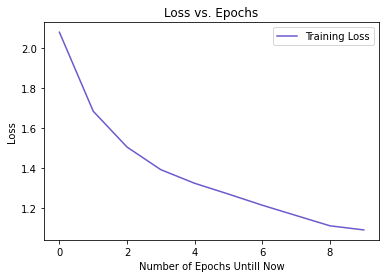

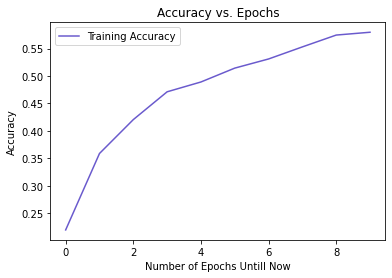

...............................................
Validating the network......
Iteration:20 	 Loss:1.06722
Iteration:40 	 Loss:1.00641
Iteration:60 	 Loss:0.98895
Iteration:80 	 Loss:0.99853
At the end of epoch 10:
The average validation loss is: 0.99775
The accuracy on validation data is: 0.59982


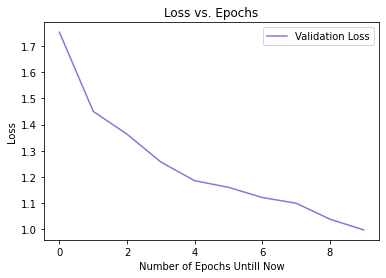

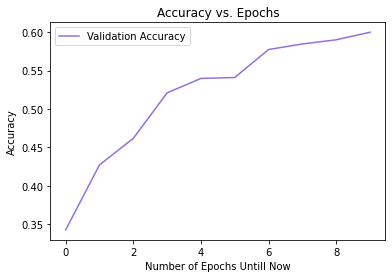

********************************************************
Epoch 11 has started......
Training the network......
Iteration:70 	 Loss:1.05334
Iteration:140 	 Loss:1.03958
Iteration:210 	 Loss:1.05155
Iteration:280 	 Loss:1.03819
Iteration:350 	 Loss:1.04058
At the end of epoch 11:
The average training loss is: 1.04017
The accuracy on training data is: 0.59658
...............................................
Validating the network......
Iteration:20 	 Loss:0.89322
Iteration:40 	 Loss:0.97028
Iteration:60 	 Loss:0.98350
Iteration:80 	 Loss:0.99497
At the end of epoch 11:
The average validation loss is: 1.00182
The accuracy on validation data is: 0.60825
********************************************************
Epoch 12 has started......
Training the network......
Iteration:70 	 Loss:1.00853
Iteration:140 	 Loss:1.02243
Iteration:210 	 Loss:1.01810
Iteration:280 	 Loss:1.00359
Iteration:350 	 Loss:1.00468
At the end of epoch 12:
The average training loss is: 1.00329
The accuracy on training da

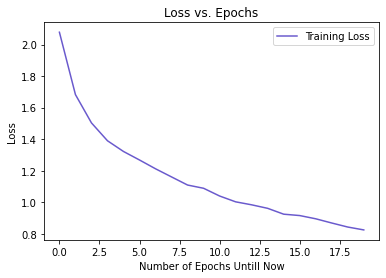

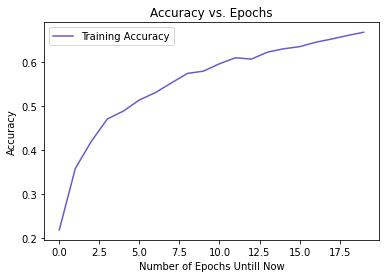

...............................................
Validating the network......
Iteration:20 	 Loss:0.84214
Iteration:40 	 Loss:0.94764
Iteration:60 	 Loss:0.92370
Iteration:80 	 Loss:0.87965
At the end of epoch 20:
The average validation loss is: 0.87971
The accuracy on validation data is: 0.64848


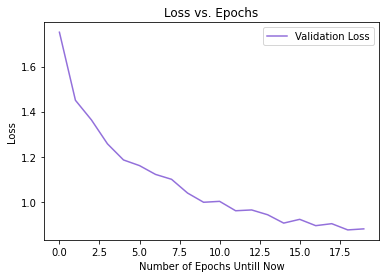

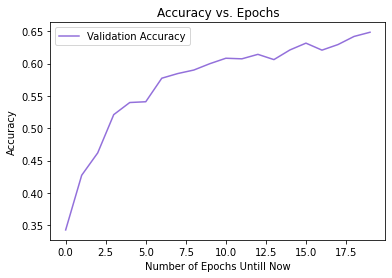

********************************************************
Epoch 21 has started......
Training the network......
Iteration:70 	 Loss:0.79752
Iteration:140 	 Loss:0.80786
Iteration:210 	 Loss:0.80376
Iteration:280 	 Loss:0.81707
Iteration:350 	 Loss:0.81918
At the end of epoch 21:
The average training loss is: 0.81866
The accuracy on training data is: 0.67704
...............................................
Validating the network......
Iteration:20 	 Loss:0.78441
Iteration:40 	 Loss:0.83983
Iteration:60 	 Loss:0.87096
Iteration:80 	 Loss:0.86064
At the end of epoch 21:
The average validation loss is: 0.85588
The accuracy on validation data is: 0.65500
********************************************************
Epoch 22 has started......
Training the network......
Iteration:70 	 Loss:0.80598
Iteration:140 	 Loss:0.79679
Iteration:210 	 Loss:0.79934
Iteration:280 	 Loss:0.79905
Iteration:350 	 Loss:0.79107
At the end of epoch 22:
The average training loss is: 0.78917
The accuracy on training da

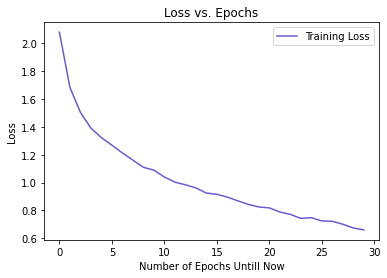

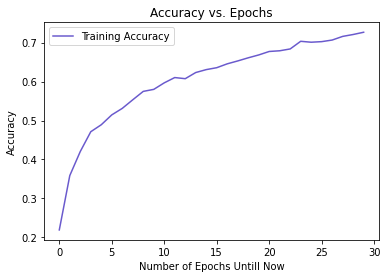

...............................................
Validating the network......
Iteration:20 	 Loss:0.79831
Iteration:40 	 Loss:0.75862
Iteration:60 	 Loss:0.75604
Iteration:80 	 Loss:0.78298
At the end of epoch 30:
The average validation loss is: 0.79422
The accuracy on validation data is: 0.67727


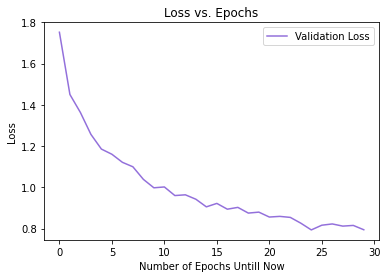

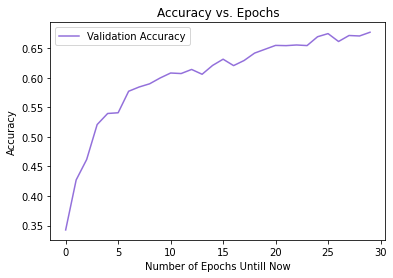

********************************************************
Epoch 31 has started......
Training the network......
Iteration:70 	 Loss:0.64724
Iteration:140 	 Loss:0.67370
Iteration:210 	 Loss:0.65875
Iteration:280 	 Loss:0.64834
Iteration:350 	 Loss:0.65496
At the end of epoch 31:
The average training loss is: 0.65526
The accuracy on training data is: 0.72760
...............................................
Validating the network......
Iteration:20 	 Loss:0.83961
Iteration:40 	 Loss:0.80697
Iteration:60 	 Loss:0.79288
Iteration:80 	 Loss:0.79927
At the end of epoch 31:
The average validation loss is: 0.79767
The accuracy on validation data is: 0.67225
********************************************************
Epoch 32 has started......
Training the network......
Iteration:70 	 Loss:0.65005
Iteration:140 	 Loss:0.63817
Iteration:210 	 Loss:0.64038
Iteration:280 	 Loss:0.65161
Iteration:350 	 Loss:0.65629
At the end of epoch 32:
The average training loss is: 0.65545
The accuracy on training da

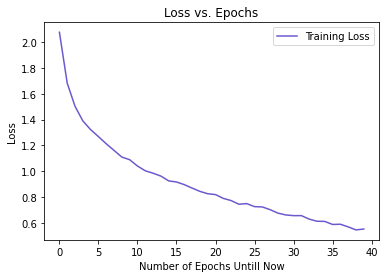

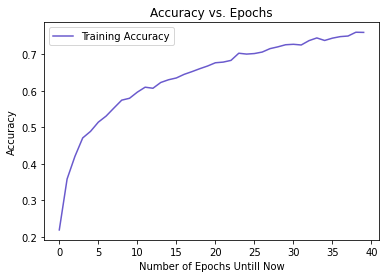

...............................................
Validating the network......
Iteration:20 	 Loss:0.88198
Iteration:40 	 Loss:0.91798
Iteration:60 	 Loss:0.91634
Iteration:80 	 Loss:0.85912
At the end of epoch 40:
The average validation loss is: 0.84832
The accuracy on validation data is: 0.67777


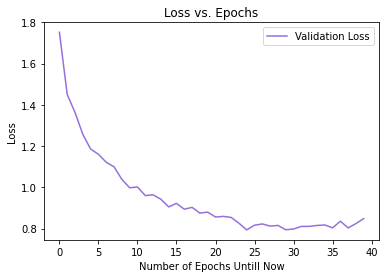

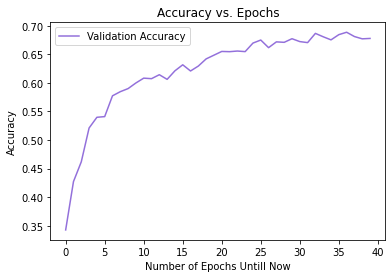

********************************************************
Epoch 41 has started......
Training the network......
Iteration:70 	 Loss:0.56202
Iteration:140 	 Loss:0.53388
Iteration:210 	 Loss:0.54071
Iteration:280 	 Loss:0.54190
Iteration:350 	 Loss:0.54813
At the end of epoch 41:
The average training loss is: 0.54657
The accuracy on training data is: 0.76189
...............................................
Validating the network......
Iteration:20 	 Loss:1.06996
Iteration:40 	 Loss:0.91990
Iteration:60 	 Loss:0.83993
Iteration:80 	 Loss:0.82467
At the end of epoch 41:
The average validation loss is: 0.81759
The accuracy on validation data is: 0.68589
********************************************************
Epoch 42 has started......
Training the network......
Iteration:70 	 Loss:0.52430
Iteration:140 	 Loss:0.53545
Iteration:210 	 Loss:0.53450
Iteration:280 	 Loss:0.54275
Iteration:350 	 Loss:0.53918
At the end of epoch 42:
The average training loss is: 0.53845
The accuracy on training da

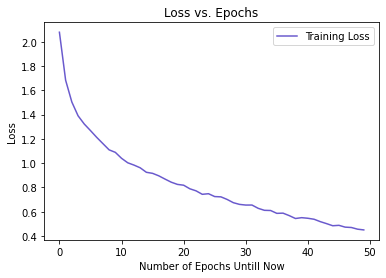

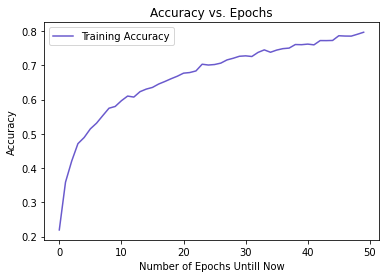

...............................................
Validating the network......
Iteration:20 	 Loss:0.81941
Iteration:40 	 Loss:0.88847
Iteration:60 	 Loss:0.89343
Iteration:80 	 Loss:0.88058
At the end of epoch 50:
The average validation loss is: 0.86214
The accuracy on validation data is: 0.68469


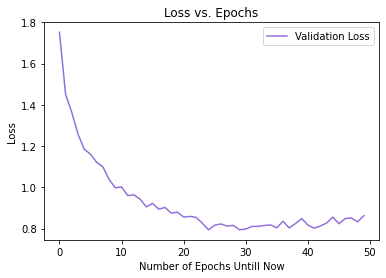

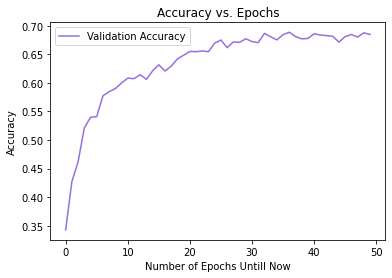

********************************************************


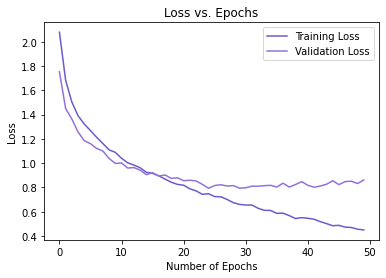

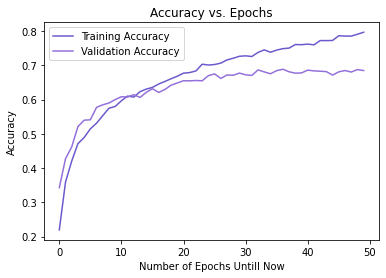

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       328
           1       0.00      0.00      0.00       156
           2       0.56      0.76      0.64       231
           3       0.70      0.86      0.77       192
           4       0.74      0.80      0.77       258
           5       0.83      0.89      0.86       292
           6       0.66      0.72      0.69       312
           7       0.71      0.85      0.77       233
           8       0.74      0.78      0.76       261
           9       0.47      0.33      0.39       454

    accuracy                           0.69      2717
   macro avg       0.62      0.69      0.65      2717
weighted avg       0.64      0.69      0.66      2717



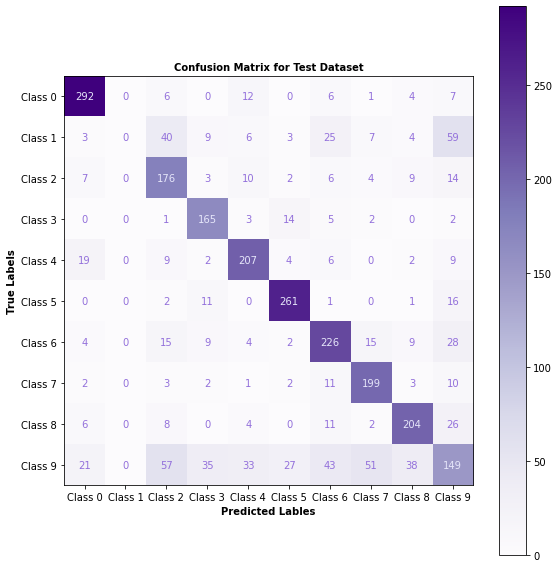

In [ ]:
train(trainDataLoader, trainDataset,
      validDataLoader, testDataLoader,
      numEpochs=50)